In [466]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Stuff important to custom Naive Bayes specifically
import pickle
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Last pre-processing

Rename the columns as well as change positive tweets from target = 4 to target = 1

In [496]:
df = pd.read_csv("../tweets-cleaned.csv", encoding='ISO-8859-1')
df = df.iloc[:, [0, 2]] # Don't want the data from before processing
df

/var/folders/wh/j0mpnsjn5dn3d140byhbb9h80000gn/T/ipykernel_4734/3147060932.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../tweets-cleaned.csv", encoding='ISO-8859-1')


,target,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1700025,4,chris great hear due time amp reminder indeed ...
1700026,4,thanks shout great aboard
1700027,4,hey long URL talk
1700028,4,matt would say URL adulthood URL


In [498]:
df['target'].replace(4, 1, inplace=True) # Replace all the 4s with 1s
df.rename(columns={'target': 'sentiment', 'text':'tweet'}, inplace=True) # Rename the columns
df

,sentiment,clean
0,0,URL aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
1700025,4,chris great hear due time amp reminder indeed ...
1700026,4,thanks shout great aboard
1700027,4,hey long URL talk
1700028,4,matt would say URL adulthood URL


In [499]:
df.dtypes

sentiment    object
clean        object
dtype: object

In [500]:
text, sentiment = list(df['clean']), list(df['sentiment']) # Turn these both into lists

text = [str(item) for item in text]
positive_text = text[850000:] # Dataset arranged in a way such that the first half is negative and second half is positive
negative_text = text[:850000]
negative_text[0].split()

['URL', 'aww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

## Word cloud for positive and negative text

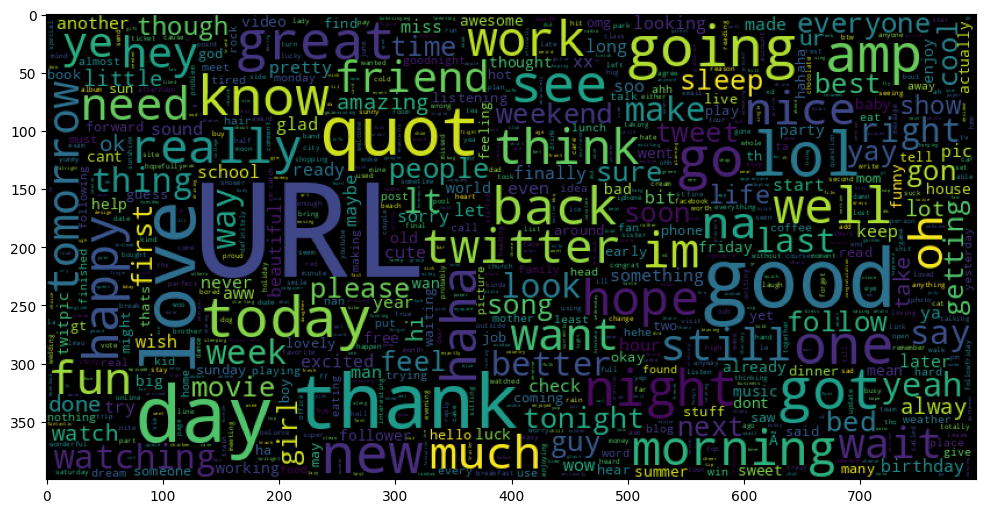

In [491]:
# Positive text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

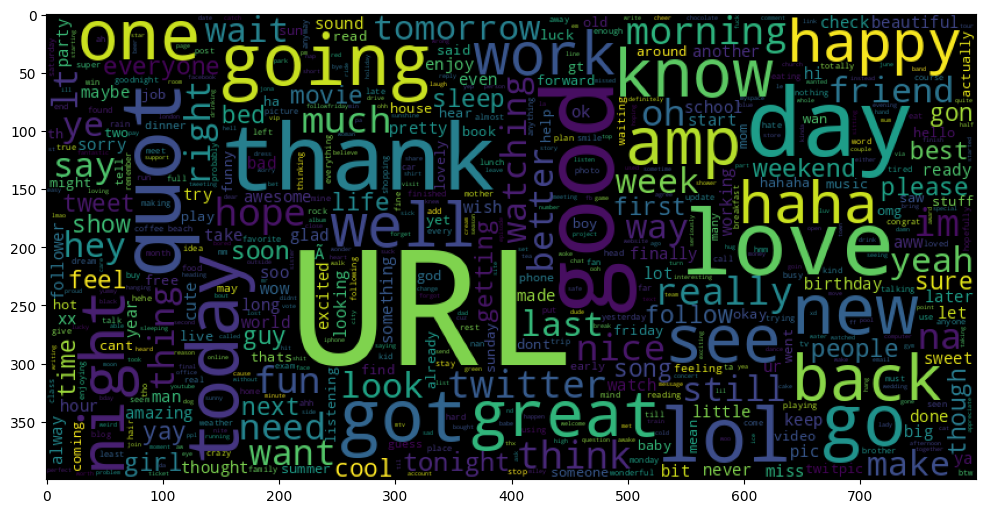

In [492]:
# Negative text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

In [501]:
with open("../stop-words.txt") as f:
    stopwords = [line.strip() for line in f]
stopwords = set(stopwords)
stopwords # Check the stop words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Naive Bayes

Implement Naive Bayes from scratch BUT also consider bigrams

In [530]:
class NaiveBayesClassifier:
    def __init__(self):
        with open("../stop-words.txt") as f:
            self.stopwords = [line.strip() for line in f]
        self.stopwords = set(self.stopwords) # Set of stop words to check against for the clean method for each prediction, keep in mind this model takes in cleaned data so should only be used for prediction

        with open("../negation-words.txt") as f:
            self.negationwords = [line.strip() for line in f]
        self.negationwords = set(self.negationwords)

        self.negative_word_count = 0 # Total number of words for each class
        self.positive_word_count = 0
        self.positive_words = {}  # Word frequencies for each class
        self.negative_words = {}

    def clean(self, text):        
        # Convert to lowercase
        message = text.lower()
        # Remove URLs. Match words that begin with http, http\S+, www, etc... and \S+ which is just one or more non-whitespace characters
        message = re.sub(r'\shttp\S+|\swww\S+|\shttps\S+', ' URL ', message, flags=re.MULTILINE)

        # Do they same as above but match with anything that ends with .com, .net, or website endings
        message = re.sub(r'\S+.com\s|\S+.net\s|\S+.org\s|\S+.co\s|\S+.us\s|\S+.edu\s|\S+.me\s|\S+.cn\s|\S+.uk\s|\S+.cn\s', ' URL ', message, flags=re.MULTILINE)
        # Get rid of @ mentions from the tweet dataset
        message = re.sub(r'@\S+', '', message, flags=re.MULTILINE)

        # Remove punctuation
        message = re.sub(r'\W', ' ', message)
        # Remove digits
        message = re.sub(r'\d+', '', message)

        # Tokenize the tweet (just store each word into a list)
        tokens = word_tokenize(message)

        tokens = [token for token in tokens if token not in stopwords] # Keep the ones that aren't a stop word

        # Lemmatize tokens, converting it back to its base form
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        tokens = [token for token in tokens if len(token) > 1] # Get rid of random letters out and about from punctuation removal
        return tokens # Return a list of tokens

    def fit(self, positive_text, negative_text):
        for i in range(len(positive_text)):
            splitted = positive_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.positive_words: # Keep track of 
                    self.positive_words[splitted[j]] = 0
                self.positive_words[splitted[j]] += 1
                self.positive_word_count += 1

        for i in range(len(negative_text)):
            splitted = negative_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.negative_words:
                    self.negative_words[splitted[j]] = 0
                self.negative_words[splitted[j]] += 1
                self.negative_word_count += 1
    
    def predict(self, text): # VERY similar to data preprocessing, 1. Preprocess 2. Run inference based off the words
        tokens = self.clean(text) # Clean the message and get tokens in the form that we want
        pos_word_prob = 1
        neg_word_prob = 1
        for i in range(len(tokens)):
            if tokens[i] in self.positive_words and tokens[i] in self.negative_words: # If this word is in both, we can simply grab it from both
                pos_word_prob *= self.positive_words[tokens[i]] / self.positive_word_count
                neg_word_prob *= self.negative_words[tokens[i]] / self.negative_word_count
            elif tokens[i] in self.positive_words: # If it's only in one of them, need to pretend we saw one of this word in the negative or positive dataset
                pos_word_prob *= self.positive_words[tokens[i]] / self.positive_word_count
                neg_word_prob *= 1 / (self.negative_word_count + len(self.negative_words)) # Divide by negative_word_count + number of words because we're pretending for each negative word, we saw more than we actually did to scale with the current word we are pretending exists
            elif tokens[i] in self.negative_words:
                neg_word_prob *= self.negative_words[tokens[i]] / self.negative_word_count
                pos_word_prob *= 1 / (self.positive_word_count + len(self.positive_words)) # Scale it up to the number of additions we need to "hallucinate"
        final_pos = pos_word_prob
        final_neg = neg_word_prob
        text_split = text.split()
        negate = False
        if len(text_split) > 2 and (text_split[0] in self.negationwords or text_split[1] in self.negationwords): # Use my list of negation words to detect if the first couple of words are a word that negates the rest
            negate = True
        if len(text_split) > 3 and text_split[2] in self.negationwords:
            negate = True
        if abs(0.5 - final_pos / (final_pos + final_neg)) < 0.05: # If there's not too much of a difference simply deem it neutral
            return 1
        if final_pos > final_neg: 
            if negate: # If we found a negation word at the start, chances are simply relying on the word's probability won't cut it so negate the outcome. Ex: Don't be harsh on yourself vs. Be harsh on yourself will be distuinguished with this
                return 0
            return 2
        else:
            if negate:
                return 2
            return 0    

In [531]:
import random
random.shuffle(positive_text)
random.shuffle(negative_text)
train_pos = positive_text[:850000]
train_neg = negative_text[:850000]

test_pos = positive_text[700000:] # The above should be :700000 to test the model but for the deployed model I will use all training examples
test_neg = negative_text[700000:]

In [532]:
Naive_Bayes = NaiveBayesClassifier()
Naive_Bayes.fit(train_pos, train_neg)
print("Training complete.")

Training complete.


In [533]:
message = "i like you"
Naive_Bayes.predict(message)

1

In [538]:
message = "this is a message"
Naive_Bayes.predict(message)

1

In [534]:
message = "I dislike you"
Naive_Bayes.predict(message)

0

In [535]:
message = "I dont dislike you"
Naive_Bayes.predict(message)

2

In [536]:
message = "I hate you"
Naive_Bayes.predict(message)

0

## Test for validation
Test the dataset to see how accurate it is

In [522]:
correct_count = 0
for i in range(len(test_pos)):
    if Naive_Bayes.predict(test_pos[i]) == 2:
        correct_count += 1
for i in range(len(test_neg)):
    if Naive_Bayes.predict(test_neg[i]) == 0:
        correct_count += 1
print("Overall accuracy on validation set:", correct_count/(len(test_pos) + len(test_neg)))

Overall accuracy on validation set: 0.7687464586874646


## Pickle the model for use in the bot


In [539]:
# Pickle the Naive Bayes classifier object
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(Naive_Bayes, f)

print("Naive Bayes model saved as naive_bayes_model.pkl")

Naive Bayes model saved as naive_bayes_model.pkl


## Try with Multinomial Naive Bayes and Logistic Regression

These are to compare the performance under optimal conditions. I will still be using my implementation of Naive Bayes from scratch for deployment because of how lightweight it is.

In [526]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42) # Get a train test split based off of Naive Bayes

In [527]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [528]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)
model_Evaluate(MultiNB)

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



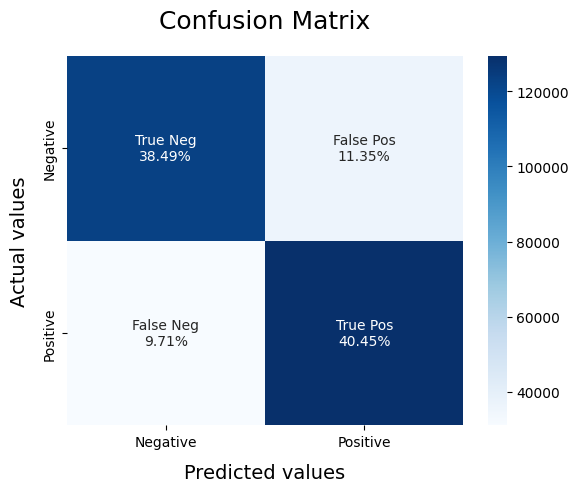

In [109]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)